### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

/Users/samantha/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/samantha/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/samantha/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/samantha/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer 

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [3]:
from afinn import Afinn

In [4]:
pd.set_option('display.max_rows',600)
pd.set_option('display.max_columns',500)

In [5]:
df = pd.read_csv('final_df_v3.csv', index_col='Unnamed: 0')

# Cleaning DF

In [6]:
df.dropna(subset=['review','rating'], inplace=True)

In [7]:
df.reset_index(drop=True, inplace=True)

## Removing Bad Strings

In [8]:
bad_str_1 = 'Follow NYT Food on Twitter and NYT Cooking on Instagram, Facebook, YouTube and Pinterest.'
bad_str_2 = 'Get regular updates from NYT Cooking, with recipe suggestions, cooking tips and shopping advice.'
bad_str_3 = 'What the stars mean: (None) Poor to Satisfactory * Good ** Very Good *** Excellent ****' 
bad_str_4 = 'Extraordinary Ratings reflect the reviewer\'s reaction primarily to food, with ambiance and service taken into consideration.' 
bad_str_5 = 'Menu listings and prices are subject to change.'
bad_str_6 = 'Extraordinary Ratings reflect the reviewer\'s reaction to food, ambiance and service with price taken into consideration.'
bad_str_7 = 'ON THE WEB PAST REVIEWS from the New York Times, with additional capsule reviews by Times critics: nytimes.com/dining'

def del_bad_str(review):
    
    for string in [bad_str_1, bad_str_2, bad_str_3, bad_str_4, bad_str_5, bad_str_6, bad_str_7]:
        
        if string in review:
            
            review = review.replace(string, '').strip()
    
    return review


In [9]:
df['review'] = df['review'].apply(lambda x: del_bad_str(x))

## Fixing Rating

In [10]:
def categorize(rating):
    if rating in ['0.25 star', '0.5 star', '0.75 star', 'Fair', 'Satisfactory', 'Poor', 'SATISFACTORY']:
        return '0 star'
    elif rating in ['1 star', '★']:
        return '★'
    elif rating in ['2 star','★★']:
        return '★★'
    else:
        return '★★★'

In [11]:
df['rating'] = df['rating'].apply(lambda x: categorize(x))

# Making a Stopwords List

In [10]:
NYT_stoplist = ['follow','nyt','food','twitter','cooking','instagram','facebook','youtube','pinterest',
 'recipe','suggestions','tips','shopping','advice','food', 'restaurant', '00',
 '000','0000','0005','0008','0030','0050','0082','0101','0105','0200','0220','0233','0242','0271','03','0303','0327',
 '0350','0404', '05', '0505', '0553', '0555', '0665', '07', '0808', '0812', '0820', '0905', '0906', '0999', 'street', 
 'ave','★','*','atmosphere','sound','wine','list','am','pm', 'daily', 'monday','tuesday','wednesday','thursday',
 'friday','saturday','sunday','hours','wheelchair','access','0003', '0012', '0020', '0033', '0085', '0100', '02',
 '0202', '0211', '0215', '0221', '0228', '0300', '0400', '0412', '0470', '0606', '0700', '08', '0844', '0880', '0955',
 'mr', 'dinner']

numbers_stoplist = [str(x) for x in range(0,2020)]



In [11]:
new_stop_words = [';','.',',','’','“','”','—', ':', '(', ')', 'nyt', '$','would', 'one', 'mr.', \
                  'came', 'table', 'get', 'year', 'water', 'go', 'along', 'first', 'second', \
                  'restaurant', 'new', 'york', 'cooking', 'shop', 'might', 'also', 'make', 'made', 'also'\
                  'food', 'menu', 'meal', 'list', 'dish', 'table', 'dining', 'server', 'food', 'room', 'floor',\
                  'served', 'may', 'want', 'brought', 'night', 'customer', 'said', 'say', 'come', 'dinner', 'le',\
                  'name', 'time', 'chef', '!', 'side', 'day', 'night', 'ate', '?', 'back', 'customers', 'restaurants',\
                  'ingredient', 'cook','dish', 'lunch', 'a.m.', 'p.m.', '\'s', 'way', 'ms.', '--', 'n\'t']

In [12]:
stop_entities = ['GPE', 'CARDINAL', 'PERSON', 'DATE']

def remove_named_entities(review):
    
    # Get Entities
    nlp = English()
    nlp = en_core_web_sm.load()
    
    doc = nlp(review)
    
    stop_entity_list = []
    entities=[(i, i.label_, i.label) for i in doc.ents]
    
    for entity in entities:
        
        if entity[1] in stop_entities:
            stop_entity_list.append(str(entity[0]).lower())

    return stop_entity_list

In [13]:
nested = []
for review in df['review']:
    se_list = remove_named_entities(review)
    nested.append(se_list)

In [14]:
stopped_entities = [word for sublist in nested for word in sublist]

In [15]:
stopped_entities = list(set(stopped_entities))

In [106]:
stopped_entities

['lupulo',
 'grateful deadish',
 'beau soleil',
 '595-1313',
 '602-1300',
 'xian',
 'prida',
 'stulman',
 'southampton',
 '212)744-1100',
 'appleman',
 'jorim',
 'arrive',
 'pierre schutz',
 'kolkata',
 'chinatowns',
 'tellicherry',
 '239',
 'chin chin',
 'karina',
 'tracy obolsky',
 'about 25',
 'alfred taubman',
 'nearly 115',
 'voltaire',
 '792',
 'gran roque',
 'ning bo fried two delights — delightful',
 'francescana',
 '1,000',
 'alicia nosenzo',
 'hours dinner',
 'wylie dufresne',
 'thanksgiving weekend',
 'emily hyland',
 'tae kyung ku',
 'lan sheng',
 'dover',
 'anthony sasso',
 'daniel radcliffe',
 'bill telepan',
 'rat pack-era',
 'most days',
 'dona’s',
 'pujol',
 'her days',
 'cobble hill',
 'marek sada',
 'astoria seafood',
 'coxsackie',
 'six years',
 'bernardaud',
 'mighty quinn’s',
 'parker',
 'the 1940s',
 'just nights later',
 'jovia  ',
 'kang ho dang baekjeong',
 'giada de laurentiis',
 'perbacco',
 'just over 30',
 'bianco',
 '490-2100',
 'several years ago',
 'nic

In [158]:
shortlist = stopwords.words('english')+ list(string.digits)+ NYT_stoplist + numbers_stoplist +['dishes', 'dish', 'new', 'sauce', 'made', 'mr.', 'room', 'table', 'would', 'new york', 'york','menu','one','two','three']+new_stop_words

In [159]:
shortlist = list(set(shortlist))

In [16]:
stopwords_list = stopwords.words('english')+ list(string.digits)+ NYT_stoplist + numbers_stoplist + [str(x) for x in range(2020, 99999)]+['dishes', 'dish', 'new', 'sauce', 'made', 'mr.', 'room', 'table', 'would', 'new york', 'york','menu','one','two','three']+new_stop_words+stopped_entities

In [17]:
stopwords_list = list(set(stopwords_list)) 

In [18]:
stopwords_list

['78339',
 '38246',
 '8202',
 '96800',
 '86611',
 '19666',
 '79485',
 '67016',
 '9504',
 '74072',
 '15873',
 '71556',
 'hammock',
 '21648',
 '22514',
 '20461',
 '75614',
 '23802',
 '56216',
 '21385',
 'and',
 '36968',
 '58282',
 '84905',
 'jared gadbaw',
 '74088',
 '98690',
 '50947',
 '59514',
 '70108',
 '86088',
 '87148',
 '28965',
 '34531',
 '39527',
 '79715',
 '86738',
 '1546',
 '96990',
 'only about a quarter',
 '8810',
 '88381',
 '99554',
 '76060',
 '11846',
 '49483',
 '99969',
 '56453',
 '32874',
 '39879',
 '88368',
 '56312',
 '93649',
 '89404',
 '30460',
 '89287',
 '11013',
 '21010',
 '53438',
 '2378',
 '73707',
 '40558',
 '46984',
 '10290',
 '78174',
 '92172',
 '62769',
 '82131',
 '56797',
 '40502',
 '77365',
 '89622',
 '95547',
 '8486',
 '20859',
 '61723',
 '18143',
 '5763',
 '28075',
 '32637',
 '66820',
 '81929',
 '7528',
 '77542',
 '78754',
 '28215',
 '22755',
 '52378',
 '32716',
 '36104',
 '77329',
 '45543',
 '84490',
 'eight-month-old',
 '45198',
 '13164',
 '46713',
 '6764

# More DF Cleaning

In [12]:
stemmer = SnowballStemmer('english')

lemmer = WordNetLemmatizer()

token = WhitespaceTokenizer()


def make_tokens(review, token):
    tokenized_review = token.tokenize(review)
    return tokenized_review

def lower(tokenized_review):
    lowercase_tokens = [token.lower() for token in tokenized_review]
    return lowercase_tokens

def remove_punc(lowercase_tokens):
    stripped_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in lowercase_tokens]
    return stripped_tokens

def remove_stopwords(stripped_tokens, stopwords_list):
    stopped_tokens = [token for token in stripped_tokens if token not in stopwords_list]
    return stopped_tokens

def stem_tokens(stopped_tokens, stemmer):
    stems = [stemmer.stem(token) for token in stopped_tokens]
    return stems

def lem_tokens(stopped_tokens, lemmer):
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    return lems

def normalize(review, stopword_list, lemmer, token):
    tokens = make_tokens(review, token)
    lower_tokens = lower(tokens)
    no_punc = remove_punc(lower_tokens)
    stopped = remove_stopwords(no_punc, stopword_list)
    lems = lem_tokens(stopped, lemmer)
    return lems

In [14]:
list_tokens = [make_tokens(x,token) for x in df['review']]

In [15]:
tokens = [val for sublist in list_tokens for val in sublist]

In [16]:
len(tokens)

826102

In [160]:
df['tokens'] = df['review'].apply(lambda x: normalize(x, shortlist, lemmer, token))

In [161]:
# Number of unique words
df['vocabulary'] = df['tokens'].apply(lambda x: len(set(x)))

In [20]:
# Number of total words
# df['num_tokens'] = df['tokens'].apply(lambda x: len(x))

In [146]:
df.drop(['cuisine','recommendations'], axis=1, inplace=True)

df = df[(df['reviewer'] == 'Pete Wells')|(df['reviewer'] == 'Frank Bruni')|(df['reviewer'] == 'Sam Sifton')]

In [149]:
def hood_to_area(hood):
    if hood in ['West Village', 'East Village', 'TriBeCa','SoHo', 'Lower East Side', 'Greenwich Village',
                'NoHo', 'Nolita', 'Financial District', 'Gramercy Park', 'Chinatown', 'Union Square', 
                'Battery Park City', 'Meatpacking District','NoLIta', 'Little Italy', 'Hudson Square','Fulton Ferry']:
        return 'Downtown'
    elif hood in ['Midtown', 'Midtown East', 'Midtown South', 'Times Square Theatre District', 'Kips Bay',
                  'Murray Hill', 'Koreatown', 'Hudson Yards', 'Chelsea', 'Flatiron district','Flatiron', 
                  'NoMad', 'Columbus Circle']:
        return 'Midtown'
    elif hood in ['Upper East Side', 'Upper West Side', 'Harlem']:
        return 'Uptown'
    
    elif hood in ['Williamsburg','Clinton', 'Park Slope','Greenpoint', 'Gowanus','Prospect Heights', 'Red Hook', 
                  'Carroll Gardens', 'Bushwick', 'Crown Heights', 'Cobble Hill', 'Boerum Hill', 'Fort Greene',
                  'Park Slope North', 'Columbia Street Waterfront District', 'Coney Island', 'Brooklyn Heights', 
                  'Bay Ridge','Ditmas', 'Downtown Brooklyn','Sheepshead Bay', 'Midwood']:
        
        return 'Brooklyn'
    else:
        
        return 'Other'


In [150]:
df['area'] = df['neighborhood'].apply(lambda x: hood_to_area(x))

In [52]:
def add_num_rating(rating):
    
    if rating == '0 star':
        return 0
    elif rating == '★':
        return 1
    elif rating == '★★':
        return 2
    else:
        return 3
    
df['num_rating'] = df['rating'].apply(lambda x: add_num_rating(x))

In [151]:
df.head()

,name,rating,review_date,reviewer,review_url,neighborhood,review,headline,area
0,Hanon,★★,2019-05-21,Pete Wells,https://www.nytimes.com/2019/05/21/dining/hano...,Williamsburg,"Hanon, a new udon shop in Williamsburg, Brookl...","Udon, Innovated for Your Pleasure",Brooklyn
1,Del Posto,★★★,2019-05-14,Pete Wells,https://www.nytimes.com/2019/05/14/dining/del-...,Chelsea,"More than a year ago, I was on the verge of re...","In Del Posto’s New Era, Cuisine and Service Ar...",Midtown
2,The Freakin Rican,★,2019-05-07,Pete Wells,https://www.nytimes.com/2019/05/07/dining/the-...,Astoria,It is true that the bacalaitos at the Freakin ...,Pasteles and Two Kinds of Fried Chicken at the...,Other
3,Wayan,★★,2019-04-23,Pete Wells,https://www.nytimes.com/2019/04/23/dining/waya...,NoLIta,If you ate at Spice Market before it closed tw...,Tapping a Family Connection to Indonesian Food,Downtown
4,Niche,★,2019-04-16,Pete Wells,https://www.nytimes.com/2019/04/16/dining/nich...,Lower East Side,"In 2012 and 2013, when people were lining up a...",Ramen Without Broth? A Chef Doubles Down on a ...,Downtown


In [152]:
df.shape

(615, 9)

In [153]:
df.describe()

,name,rating,review_date,reviewer,review_url,neighborhood,review,headline,area
count,615,615,615,615,615,614,615,615,615
unique,599,4,615,3,615,68,615,614,5
top,Momofuku Ssam Bar,★★,2011-07-05,Pete Wells,https://www.nytimes.com/2018/11/27/dining/sain...,West Village,"IT’S time for a quiz. A diagnostic test, reall...",Aquavit in Midtown,Downtown
freq,3,253,1,304,1,65,1,2,277


# Sentiment Analysis

In [24]:
af = Afinn()

In [155]:
# df['afinn_score'] = df['review'].apply(lambda x: af.score(x))

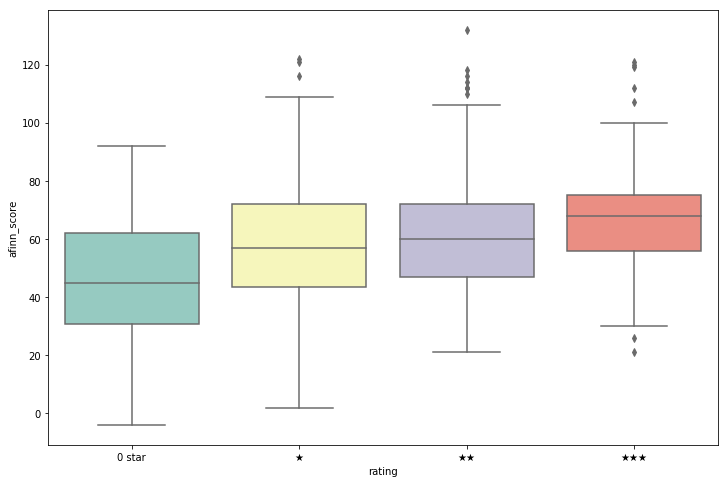

In [156]:
# plt.figure(figsize=(12,8))
# sns.boxplot(df['rating'], df['afinn_score'], palette ='Set3', order= ['0 star','★','★★','★★★'])

In [157]:


def blob_polarity(review):
    
    polarity = []
    
    for sentence in sent_tokenize(review):
        polarity.append(af.score(sentence))
    
    avg_pol = np.mean(polarity)
    min_pol = np.min(polarity)
    max_pol = np.max(polarity)
    std_pol = np.std(polarity)
    
    return avg_pol, min_pol, max_pol, std_pol

def add_blob_pol(df):
    
    df['af_avg_pol'] = df['review'].apply(lambda x: blob_polarity(x)[0])
    df['af_min_pol'] = df['review'].apply(lambda x: blob_polarity(x)[1])
    df['af_max_pol'] = df['review'].apply(lambda x: blob_polarity(x)[2])
    df['af_std_pol'] = df['review'].apply(lambda x: blob_polarity(x)[3])
    
#     df['sentiment'] = np.where(df['blob_avg_pol'] > 0.05, 1, 0)
        
    return df

df = add_blob_pol(df)

In [162]:
df.head()

,name,rating,review_date,reviewer,review_url,neighborhood,review,headline,area,afinn_score,af_avg_pol,af_min_pol,af_max_pol,af_std_pol,tokens,vocabulary
0,Hanon,★★,2019-05-21,Pete Wells,https://www.nytimes.com/2019/05/21/dining/hano...,Williamsburg,"Hanon, a new udon shop in Williamsburg, Brookl...","Udon, Innovated for Your Pleasure",Brooklyn,39.0,0.886364,-2.0,6.0,1.654414,"[hanon, udon, williamsburg, brooklyn, produced...",416
1,Del Posto,★★★,2019-05-14,Pete Wells,https://www.nytimes.com/2019/05/14/dining/del-...,Chelsea,"More than a year ago, I was on the verge of re...","In Del Posto’s New Era, Cuisine and Service Ar...",Midtown,53.0,0.716216,-6.0,8.0,2.016957,"[ago, verge, reviewing, del, posto, news, inte...",606
2,The Freakin Rican,★,2019-05-07,Pete Wells,https://www.nytimes.com/2019/05/07/dining/the-...,Astoria,It is true that the bacalaitos at the Freakin ...,Pasteles and Two Kinds of Fried Chicken at the...,Other,45.0,0.865385,-2.0,5.0,1.593603,"[true, bacalaitos, freakin, rican, astoria, qu...",471
3,Wayan,★★,2019-04-23,Pete Wells,https://www.nytimes.com/2019/04/23/dining/waya...,NoLIta,If you ate at Spice Market before it closed tw...,Tapping a Family Connection to Indonesian Food,Downtown,36.0,0.750000,-4.0,5.0,1.854050,"[spice, market, closed, year, ago, experience,...",425
4,Niche,★,2019-04-16,Pete Wells,https://www.nytimes.com/2019/04/16/dining/nich...,Lower East Side,"In 2012 and 2013, when people were lining up a...",Ramen Without Broth? A Chef Doubles Down on a ...,Downtown,19.0,0.387755,-4.0,4.0,1.536180,"[people, lining, smorgasburg, houston, whole, ...",414


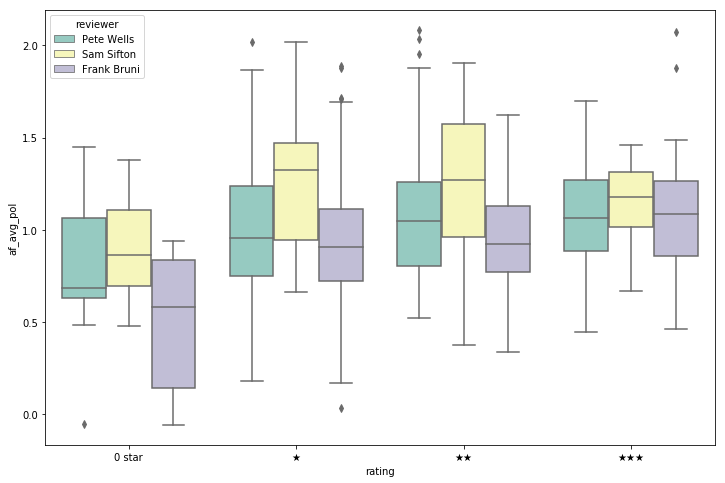

In [163]:
plt.figure(figsize=(12,8))
sns.boxplot(df['rating'], df['af_avg_pol'], palette ='Set3', order= ['0 star','★','★★','★★★'], hue=df['reviewer'])

In [170]:
df['headline_sent'] = df['headline'].apply(lambda x: af.score(x))

In [33]:
# sent_tokens = sent_tokenize(df['review'][0])

In [34]:
# polarity = [af.score(x) for x in sent_tokens]

In [44]:
# list(zip(sent_tokens, polarity))

[('Hanon, a new udon shop in Williamsburg, Brooklyn, was produced by the union of a Tokyo video-production company and a Japanese manufacturer of unusually thin condoms.',
  0.0),
 ('The condoms became the subject of a series of advertisements on which the production company worked; in one of them, called “Acts of Love,” dancers in London re-enact, with surprising grace and dignity, the mating rituals of blue-footed boobies, fiddler crabs and other animals.',
  6.0),
 ('Well, kids, when two companies like each other very much, sometimes they decide to create a new company together.',
  2.0),
 ('That is what happened with the production firm and the prophylactics people when, for reasons that are perhaps best not to question, they hit upon the idea of expanding their product line from condoms into noodles.',
  3.0),
 ('The restaurant lies across Union Avenue from Kellogg’s Diner.', 0.0),
 ('Its door is marked during business hours by the fluttering white noren curtains.',
  0.0),
 ('It 

In [45]:
# sum(polarity)

39.0

In [49]:
# tokens0 = []
# tokens1 = []
# tokens2 = []
# tokens3 = []

# for i in range(0,len(df)):
#     if df.iloc[i]['rating'] == '0 star':
#         tokens0.append(df.iloc[i]['review'])
#     elif df.iloc[i]['rating'] == '★':
#         tokens1.append(df.iloc[i]['review'])
#     if df.iloc[i]['rating'] == '★★':
#         tokens2.append(df.iloc[i]['review'])
#     if df.iloc[i]['rating'] == '★★★':
#         tokens3.append(df.iloc[i]['review'])

In [56]:
# vec0 = TfidfVectorizer(stop_words=stopwords_list_3,preprocessor=lambda x: stemmer.stem(x), ngram_range=(1,3),max_features = 20)
# vec1 = TfidfVectorizer(stop_words=stopwords_list_3,preprocessor=lambda x: stemmer.stem(x), ngram_range=(1,3),max_features = 20)
# vec2 = TfidfVectorizer(stop_words=stopwords_list_3,preprocessor=lambda x: stemmer.stem(x), ngram_range=(1,3),max_features = 20)
# vec3 = TfidfVectorizer(stop_words=stopwords_list_3,preprocessor=lambda x: stemmer.stem(x), ngram_range=(1,3),max_features = 20)

In [82]:
# vec0 = TfidfVectorizer(stop_words=stopwords_list,ngram_range=(1,3),max_features = 20)
# vec1 = TfidfVectorizer(stop_words=stopwords_list,ngram_range=(1,3),max_features = 20)
# vec2 = TfidfVectorizer(stop_words=stopwords_list,ngram_range=(1,3),max_features = 20)
# vec3 = TfidfVectorizer(stop_words=stopwords_list,ngram_range=(1,3),max_features = 20)

In [83]:
# tfidf0 = vec0.fit_transform(tokens0)
# tfidf1 = vec1.fit_transform(tokens1)
# tfidf2 = vec2.fit_transform(tokens2)
# tfidf3 = vec3.fit_transform(tokens3)

/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['new'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing

In [84]:
# tfidf_df0 = pd.DataFrame(tfidf0.toarray(), columns=vec0.get_feature_names())
# tfidf_df1 = pd.DataFrame(tfidf1.toarray(), columns=vec1.get_feature_names())
# tfidf_df2 = pd.DataFrame(tfidf2.toarray(), columns=vec2.get_feature_names())
# tfidf_df3 = pd.DataFrame(tfidf3.toarray(), columns=vec3.get_feature_names())

# TF-IDF Analysis

In [19]:
tfidf_total = TfidfVectorizer(stop_words=stopwords_list)

In [20]:
tfidf_total.fit(df['review'])

/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0776', '0898', '10downingnyc', '10th', '11th', '15eastrestaurant', '15th', '18th', '190a', '1920s', '1940s', '1990s', '2000s', '20s', '20th', '21st', '29th', '30a', '32nd', '39th', '41st', '42nd', '44th', '55th', '58th', '60s', '64th', '80th', '81st', '9th', 'aaron', 'aarón', 'ababa', 'abby', 'abdellah', 'abela', 'abraham', 'abram', 'abu', 'aby', 'accarrino', 'accepted', 'acheson', 'adam', 'adams', 'addeo', 'addis', 'adlgasser', 'adolf', 'africa', 'afrim', 'age', 'agostino', 'ahead', 'ahram', 'ai', 'aidala', 'aidan', 'ailey', 'aizpitarte', 'ajna', 'akira', 'alam', 'alana', 'albert', 'aldo', 'alessandro', 'alevras', 'alex', 'alexander', 'alexandra', 'alexandria', 'alfred', 'alicia', 'alina', 'alistair', 'allison', 'almond', 'almost', 'alphart', 'although', 'altro', 'alvarez', '

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['78339', '38246', '8202', '96800', '86611', '19666', '79485', '67016', '9504', '74072', '15873', '71556', 'hammock', '21648', '22514', '20461', '75614', '23802', '56216', '21385', 'and', '36968', '58282', '84905', 'jared gadbaw', '74088', '98690', '50947', '59514', '70108', '86088', '871...ng', 'pierre schutz', '28924', '1714', '22300', '64031', '77727', 'little pepper', '10778', '77098'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
tfidf_total_transform = tfidf_total.transform(df['review'])

In [22]:
ngrams = tfidf_total.get_feature_names()

In [25]:
ngram_polarity = [(word, af.score(word)) for word in ngrams]

In [26]:
polar_words = []
for word,score in ngram_polarity:
    if score != 0:
        polar_words.append((word, score))

In [27]:
most_polar_words = []
for word,score in polar_words:
    if score < -3 or score > 3:
        most_polar_words.append((word, score))

In [28]:
most_polar_words

[('amazing', 4.0),
 ('awesome', 4.0),
 ('bastard', -5.0),
 ('breathtaking', 5.0),
 ('brilliant', 4.0),
 ('catastrophic', -4.0),
 ('damned', -4.0),
 ('ecstatic', 4.0),
 ('euphoric', 4.0),
 ('exuberant', 4.0),
 ('fabulous', 4.0),
 ('fantastic', 4.0),
 ('fraud', -4.0),
 ('fun', 4.0),
 ('funnier', 4.0),
 ('funny', 4.0),
 ('godsend', 4.0),
 ('heavenly', 4.0),
 ('hell', -4.0),
 ('masterpiece', 4.0),
 ('miracle', 4.0),
 ('outstanding', 5.0),
 ('prick', -5.0),
 ('rape', -4.0),
 ('rapturous', 4.0),
 ('rejoice', 4.0),
 ('slut', -5.0),
 ('stunning', 4.0),
 ('superb', 5.0),
 ('supreme', 4.0),
 ('terrific', 4.0),
 ('terrifically', 4.0),
 ('thrilled', 5.0),
 ('torture', -4.0),
 ('tortured', -4.0),
 ('triumph', 4.0),
 ('triumphant', 4.0),
 ('win', 4.0),
 ('winning', 4.0),
 ('wins', 4.0),
 ('wonderful', 4.0),
 ('wonderfully', 4.0),
 ('wow', 4.0)]

In [32]:
tfidf_vocab = [word for word, score in most_polar_words]

In [33]:
tfidf_vocab = list(set([lemmer.lemmatize(x) for x in tfidf_vocab]))

In [34]:
tfidf_total_df = pd.DataFrame(tfidf_total_transform.toarray(), columns = ngrams)

In [35]:
tfidf_total_df[tfidf_vocab]

,miracle,breathtaking,euphoric,tortured,ecstatic,slut,triumphant,hell,wonderfully,godsend,rejoice,superb,fun,outstanding,thrilled,triumph,fantastic,damned,masterpiece,exuberant,terrifically,stunning,terrific,funnier,awesome,supreme,wow,heavenly,catastrophic,bastard,amazing,funny,brilliant,win,fabulous,rapturous,wonderful,rape,fraud,winning,prick,torture
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018151,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034632,0.000000,0.000000,0.000000,0.000000,0.018678,0.000000,0.000000,0.000000,0.0,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

# Creating a DF for Modeling

In [53]:
modeling = df.copy()

In [177]:
modeling.shape

(615, 17)

In [54]:
modeling.reset_index(drop=True, inplace=True)

In [179]:
modeling = pd.concat([modeling,tfidf_total_df[tfidf_vocab]], axis=1)

In [180]:
modeling.shape

(615, 57)

In [194]:
ohe_rev = OneHotEncoder(sparse=False)
ohe_area = OneHotEncoder(sparse=False)

In [195]:
reviewer_dummies = ohe_rev.fit_transform(np.array(df['reviewer']).reshape(-1,1))

In [205]:
reviewer_dum_df = pd.DataFrame(reviewer_dummies, columns = ohe_rev.get_feature_names())

In [198]:
area_dummies = ohe_area.fit_transform(np.array(df['area']).reshape(-1,1))

In [207]:
area_dum_df = pd.DataFrame(area_dummies, columns = ohe_area.get_feature_names())

In [210]:
modeling = pd.concat([modeling, reviewer_dum_df, area_dum_df], axis=1)

In [211]:
modeling.shape

(615, 65)

In [212]:
modeling.columns

Index(['name', 'rating', 'review_date', 'reviewer', 'review_url',
       'neighborhood', 'review', 'headline', 'area', 'afinn_score',
       'af_avg_pol', 'af_min_pol', 'af_max_pol', 'af_std_pol', 'tokens',
       'vocabulary', 'headline_sent', 'funny', 'awesome', 'bastard', 'funnier',
       'fantastic', 'ecstatic', 'catastrophic', 'tortured', 'amazing',
       'triumphant', 'exuberant', 'masterpiece', 'fun', 'heavenly', 'miracle',
       'wow', 'fraud', 'godsend', 'rapturous', 'breathtaking', 'superb',
       'winning', 'supreme', 'fabulous', 'prick', 'damned', 'brilliant',
       'triumph', 'wonderful', 'terrific', 'terrifically', 'thrilled',
       'rejoice', 'win', 'stunning', 'slut', 'wonderfully', 'torture',
       'outstanding', 'hell', 'x0_Frank Bruni', 'x0_Pete Wells',
       'x0_Sam Sifton', 'x0_Brooklyn', 'x0_Downtown', 'x0_Midtown', 'x0_Other',
       'x0_Uptown'],
      dtype='object')

In [213]:
modeling.to_csv('modeling.csv')

In [83]:
modeling.drop(['name','review_date','review_url','neighborhood','review','tokens','afinn_score','af_min_pol','af_max_pol'], axis=1, inplace=True)

In [55]:
rev_x = modeling['review']
rev_y = modeling['num_rating']

In [56]:
def tfidf(X, y,  stopwords_list): 
    '''
    Generate train and test TF-IDF vectorization for our data set
    
    Parameters
    ----------
    X: pandas.Series object
        Pandas series of text documents to classify 
    y : pandas.Series object
        Pandas series containing label for each document
    stopwords_list: list ojbect
        List containing words and punctuation to remove. 
    Returns
    --------
    tf_idf_train :  sparse matrix, [n_train_samples, n_features]
        Vector representation of train data
    tf_idf_test :  sparse matrix, [n_test_samples, n_features]
        Vector representation of test data
    y_train : array-like object
        labels for training data
    y_test : array-like object
        labels for testing data
    vectorizer : vectorizer object
        fit TF-IDF vecotrizer object

    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    vec = TfidfVectorizer(stop_words=stopwords_list)
    
    tf_idf_train = vec.fit_transform(X_train)
    tf_idf_test = vec.transform(X_test)
    
    return tf_idf_train, tf_idf_test, y_train, y_test, vec


In [57]:
X_train, X_test, y_train, y_test, vec = tfidf(rev_x, rev_y,  stopwords_list)

/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['0776', '0898', '10downingnyc', '10th', '11th', '15eastrestaurant', '15th', '18th', '190a', '1920s', '1940s', '1990s', '2000s', '20s', '20th', '21st', '29th', '30a', '32nd', '39th', '41st', '42nd', '44th', '55th', '58th', '60s', '64th', '80th', '81st', '9th', 'aaron', 'aarón', 'ababa', 'abby', 'abdellah', 'abela', 'abraham', 'abram', 'abu', 'aby', 'accarrino', 'accepted', 'acheson', 'adam', 'adams', 'addeo', 'addis', 'adlgasser', 'adolf', 'africa', 'afrim', 'age', 'agostino', 'ahead', 'ahram', 'ai', 'aidala', 'aidan', 'ailey', 'aizpitarte', 'ajna', 'akira', 'alam', 'alana', 'albert', 'aldo', 'alessandro', 'alevras', 'alex', 'alexander', 'alexandra', 'alexandria', 'alfred', 'alicia', 'alina', 'alistair', 'allison', 'almond', 'almost', 'alphart', 'although', 'altro', 'alvarez', '

In [58]:
def classify_text(classifier, tf_idf_train, tf_idf_test, y_train):
    '''
    Train a classifier to identify whether a message is spam or ham
    
    Parameters
    ----------
    classifier: sklearn classifier
       initialized sklearn classifier (MultinomialNB, RandomForestClassifier, etc.)
    tf_idf_train : sparse matrix, [n_train_samples, n_features]
        TF-IDF vectorization of train data
    tf_idf_test : sparse matrix, [n_test_samples, n_features]
        TF-IDF vectorization of test data
    y_train : pandas.Series object
        Pandas series containing label for each document in the train set
    Returns
    --------
    train_preds :  list object
        Predictions for train data
    test_preds :  list object
        Predictions for test data
    '''
    #fit the classifier with our training data
    classifier.fit(tf_idf_train, y_train)
    
    #predict the labels of our train data and store them in train_preds
    train_preds = classifier.predict(tf_idf_train)

    #predict the labels of our test data and store them in test_preds
    test_preds = classifier.predict(tf_idf_test)
    
    return train_preds, test_preds

In [59]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [60]:
#generate predictions for Naive Bayes Classifier
nb_train_preds, nb_test_preds = classify_text(nb_classifier,X_train, X_test, y_train)

In [61]:
print(confusion_matrix(y_test, nb_test_preds, labels=[0,1,2,3]))
print(accuracy_score(y_test, nb_test_preds))

[[ 0  0  9  0]
 [ 0  0 73  0]
 [ 0  0 76  0]
 [ 0  0 19  0]]
0.4293785310734463


In [62]:
#generate predictions for Random Forest Classifier
rf_train_preds, rf_test_preds = classify_text(rf_classifier,X_train, X_test, y_train)

In [63]:
print(confusion_matrix(y_test, rf_test_preds, labels=[0,1,2,3]))
print(accuracy_score(y_test, rf_test_preds))

[[ 0  5  4  0]
 [ 0 25 48  0]
 [ 0 20 56  0]
 [ 0  3 15  1]]
0.4632768361581921


In [66]:
mmdf = pd.read_csv('most_meaningful.csv', index_col='Unnamed: 0')

In [67]:
mmdf.head()

,name,rating,review_date,reviewer,review_url,neighborhood,cuisine,recommendations,review,headline,num_rating,headline_sentiment,blob_avg_pol,blob_min_pol,blob_max_pol,blob_std_pol,sentiment,most_meaningful,most_meaningful_2
0,Hanon,★★,2019-05-21,Pete Wells,https://www.nytimes.com/2019/05/21/dining/hano...,Brooklyn,Japanese,Japanese omelet; fried chicken with spice; ric...,"Hanon, a new udon shop in Williamsburg, Brookl...","Udon, Innovated for Your Pleasure",2,0.000000,0.011658,-0.800000,0.500000,0.265241,0,"['hanon', 'udon', 'zenryufun', 'condoms', 'yan...","['zenryufun', 'condoms', 'noodles', 'noodle', ..."
1,Del Posto,★★★,2019-05-14,Pete Wells,https://www.nytimes.com/2019/05/14/dining/del-...,Midtown,Italian,Grilled salsify salad; vitello tonnato; minest...,"More than a year ago, I was on the verge of re...","In Del Posto’s New Era, Cuisine and Service Ar...",3,0.136364,0.142618,-0.600000,0.500000,0.205729,1,"['posto', 'del', 'rodriguez', 'batali', 'emplo...","['posto', 'del', 'employees', 'mr', 'italian',..."
2,The Freakin Rican,★,2019-05-07,Pete Wells,https://www.nytimes.com/2019/05/07/dining/the-...,Other,"Caribbean, Latin American",Alcapurrias; pasteles; bacalaitos; chicharrone...,It is true that the bacalaitos at the Freakin ...,Pasteles and Two Kinds of Fried Chicken at the...,1,-0.600000,0.080008,-0.600000,0.666667,0.211840,1,"['rican', 'freakin', 'puerto', 'lópez', 'paste...","['rican', 'freakin', 'pasteles', 'rico', 'chic..."
3,Wayan,★★,2019-04-23,Pete Wells,https://www.nytimes.com/2019/04/23/dining/waya...,Downtown,Indonesian,Hearts-of-palm salad; clams Jimbaran style; av...,If you ate at Spice Market before it closed tw...,Tapping a Family Connection to Indonesian Food,2,0.000000,0.104236,-0.250000,0.700000,0.196172,1,"['wayan', 'vongerichten', 'indonesia', 'indone...","['wayan', 'indonesian', 'spice', 'gado', 'ochi..."
4,Niche,★,2019-04-16,Pete Wells,https://www.nytimes.com/2019/04/16/dining/nich...,Downtown,Japanese,Avocado crunch; yuzu scallop crudo; umami komb...,"In 2012 and 2013, when people were lining up a...",Ramen Without Broth? A Chef Doubles Down on a ...,1,-0.155556,0.073833,-0.433333,0.600000,0.173327,1,"['mazemen', 'nakamura', 'ramen', 'noodles', 'k...","['mazemen', 'noodles', 'kombu', 'abura', 'bowl..."


In [68]:
for i in range(len(mmdf)):
    print(mmdf.iloc[i]['name'], '-->', mmdf.iloc[i]['most_meaningful_2'])

Hanon --> ['zenryufun', 'condoms', 'noodles', 'noodle', 'bran', 'germ', 'sasauchi', 'bamboo', 'production', 'dashi']
Del Posto --> ['posto', 'del', 'employees', 'mr', 'italian', 'ms', 'harassment', 'cacciatore', 'priorities', 'power']
The Freakin Rican --> ['rican', 'freakin', 'pasteles', 'rico', 'chicharrones', 'mofongo', 'plantains', 'adela', 'bacalaitos', 'mojo']
Wayan --> ['wayan', 'indonesian', 'spice', 'gado', 'ochi', 'resorts', 'satay', 'market', 'fruit', 'peanut']
Niche --> ['mazemen', 'noodles', 'kombu', 'abura', 'bowl', 'yuji', 'shake', 'shio', 'noodle', 'fries']
Haenyeo --> ['dok', 'suni', 'korean', 'ms', 'tteokbokki', 'hwa', 'seaweed', 'mother', '32nd', 'bibimbap']
Standard Grill --> ['standard', 'pacific', 'changing', 'union', 'game', 'mr', 'charcoal', 'blog', 'pioneer', 'items']
Violet --> ['forno', 'pizza', 'rhode', 'piri', 'pies', 'emmy', 'island', 'dough', 'atwells', 'havarti']
Odo --> ['kasu', 'shabu', 'mr', 'sake', 'tell', 'speakeasy', 'island', 'tastes', 'mochi', 's

Blue Ribbon Sushi Bar and Grill --> ['blue', 'mahi', 'pu', 'sashimi', 'roll', 'bones', 'bromberg', 'bar', 'hotel', 'tempura']
Barbuto --> ['cause', 'book', 'chickens', 'garage', 'poultry', 'oven', 'rule', 'putting', 'accessorizes', 'congratulation']
Harry Cipriani --> ['95', 'bellini', 'netherland', 'cram', 'fifth', 'carpaccio', 'calamari', 'veal', 'family', 'tonnato']
Moim --> ['korean', 'bi', 'bim', 'tricolor', 'bop', 'ms', 'visits', 'sating', 'gathering', 'seventh']
Gemma --> ['fritto', 'misto', 'calzone', 'candles', 'hotel', 'strozzapreti', 'proprietors', 'blossoms', 'design', 'fashionable']
Peter Luger Steak House --> ['steak', 'steakhouse', 'porterhouse', '95', 'porterhouses', 'sometimes', 'notice', 'gluttony', 'fudge', 'canadian']
Soto --> ['soto', 'uni', 'langoustine', 'shiitake', 'kampachi', 'roe', 'geoduck', 'tartare', 'deep', 'sashimi']
Rayuela --> ['ceviches', 'drip', 'pollo', 'rellena', 'freestyle', 'pouch', 'thump', 'latino', 'allen', 'well']
Cafe Boulud --> ['section', '

Rouge Tomate --> ['tomate', 'rouge', 'farhi', 'fleischnacke', 'bentel', 'alcoholic', 'cocotte', 'practicing', 'ponder', '60th']
SD26 --> ['sd26', 'domenico', 'san', 'tablet', 'old', 'bollito', 'explain', 'carpaccio', 'italian', '26th']
White Gold Butchers --> ['gold', 'butchers', 'butcher', 'dukkah', 'potato', 'raviolo', 'pasty', 'never', 'stems', 'pork']
La Promenade Des Anglais --> ['promenade', 'des', 'demure', 'trofie', 'leeks', 'clam', 'terrace', 'discovered', 'approach', 'starchy']
Shang --> ['chinese', 'regaled', 'spires', 'crispy', 'pathetic', 'soups', 'aware', 'orchard', 'cucumber', 'arresting']
La Silhouette --> ['silhouette', 'outskirts', 'popcorn', 'foie', 'gras', 'raviolo', 'hell', 'always', 'marshmallow', 'forgotten']
SHO Shaun Hergatt --> ['sho', 'shaun', 'hearts', 'frogs', 'vide', 'striped', 'emilie', 'escolar', 'goldman', 'sous']
Le Caprice --> ['caprice', 'haddock', 'british', 'shrimpton', '61st', 'bang', 'hear', 'actors', 'toffee', 'fries']
Lyon --> ['lyon', 'bouchon